### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%pip install wordcloud

### Exploratory Data Analysis

In [3]:
#Load the data

# data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter = '\t', quoting = 3)
data = pd.read_csv("/content/train.csv")

print(f"Dataset shape : {data.shape}")

Dataset shape : (16000, 2)


In [4]:
data.head()

,category,text
0,politic,jdu national executive meet nitish kumar says ...
1,cricket,cas financial tussle states nick hockley confi...
2,cricket,rajasthan royals vs sunrisers hyderabad ipl 20...
3,cricket,county pilots return crowds cancelled uk gover...
4,cricket,robson grit gives middlesex tough task lowscor...


In [5]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['category' 'text']


In [6]:
#Check for null values

data.isnull().sum()

,0
category,0
text,0


Datatypes of the features

In [7]:
data.dtypes

,0
category,object
text,object


In [8]:
len(data)

16000

In [9]:
data.columns

Index(['category', 'text'], dtype='object')

Let's plot the above values in a bar graph

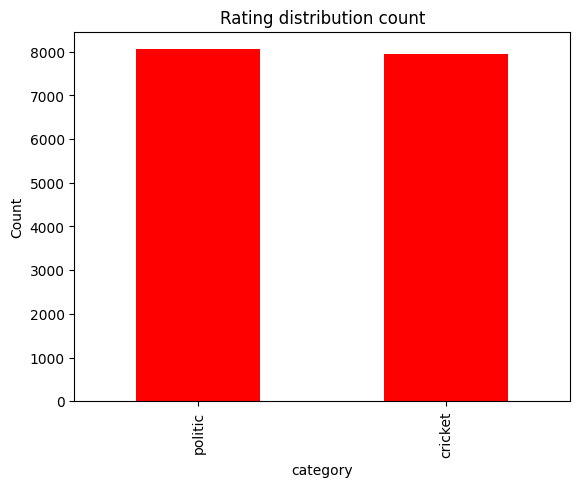

In [10]:
#Bar plot to visualize the total counts of each rating

data['category'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('category')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each category - we'll divide the number of records for each rating by total number of records

print(f"category value count - percentage distribution: \n{round(data['category'].value_counts()/data.shape[0]*100,2)}")

category value count - percentage distribution: 
category
politic    50.34
cricket    49.66
Name: count, dtype: float64


Let's plot the above values in a pie chart

In [12]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.text)

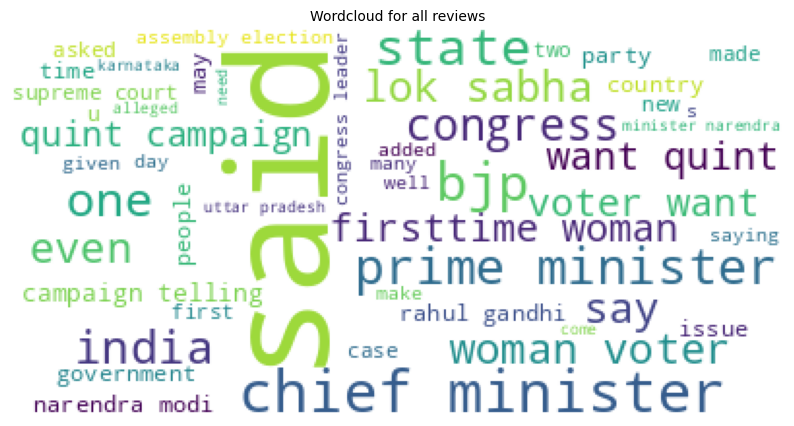

In [13]:
# Combine all reviews
reviews = " ".join([review for review in data['text']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [14]:
# Combine all reviews for each feedback category and splitting them into individual words
politic = " ".join([review for review in data[data['category'] == 'politic']['text']])
politic = politic.split()

cricket = " ".join([review for review in data[data['category'] == 'cricket']['text']])
cricket = cricket.split()

#Finding words from reviews which are present in that feedback category only
unique_politic = [x for x in politic if x not in cricket]
unique_politic = " ".join(unique_politic)

unique_cricket = [x for x in cricket if x not in politic]
unique_cricket = " ".join(unique_cricket)


KeyboardInterrupt: 

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_cricket))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_politic))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [15]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [17]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(data['category'])


In [19]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [20]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (16000, 2500)
y shape: (16000,)


Splitting data into train and test set with 30% data with testing.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (11200, 2500)
y train: (11200,)
X test: (4800, 2500)
y test: (4800,)


In [22]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 98
X test max value: 88


We'll scale X_train and X_test so that all values are between 0 and 1.

In [23]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [25]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

#### Random Forest

In [26]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [27]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9989583333333333


In [28]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [29]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

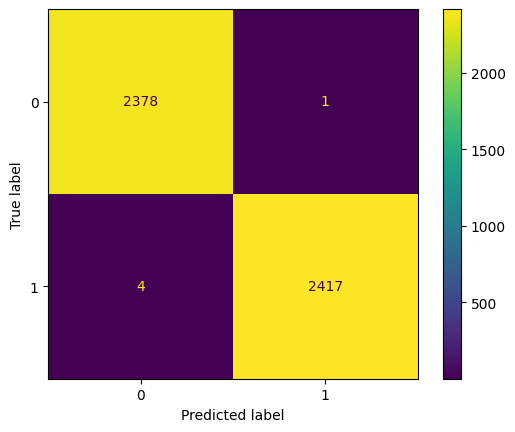

In [30]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [31]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.999375
Standard Variance : 0.0005717075211993595


Applying grid search to get the optimal parameters on random forest

In [32]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [33]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [34]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 12, 'n_estimators': 100}


In [35]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.98995535714286
Cross validation mean accuracy on test set : 99.93080357142857
Accuracy score for test set : 0.9989583333333333


#### XgBoost

In [36]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9999107142857143
Testing Accuracy : 0.9977083333333333


In [38]:
y_preds = model_xgb.predict(X_test)

In [39]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2339   40]
 [   7 2414]]


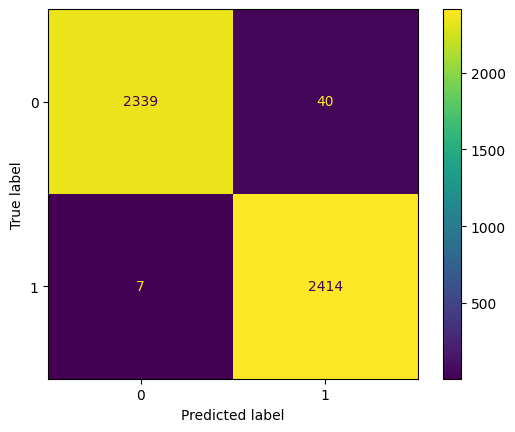

In [40]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [42]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [43]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [44]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9960416666666667


In [45]:
y_preds = model_dt.predict(X_test)

In [46]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2318   61]
 [   4 2417]]


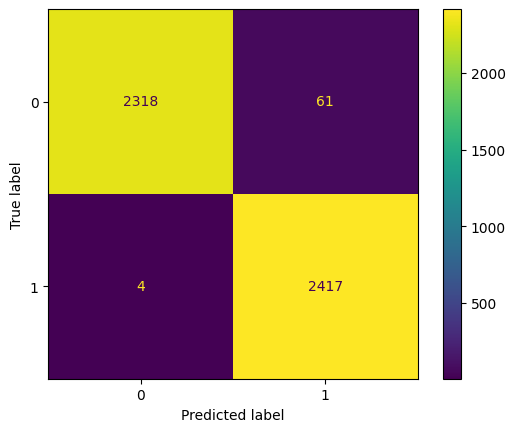

In [47]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()